In [1]:
import azureml.core
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from azureml.core import Dataset, Environment, Experiment, Model, ScriptRunConfig, Workspace
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.model import InferenceConfig 
from azureml.widgets import RunDetails

In [2]:
print(azureml.core.VERSION)

1.18.0


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Take a look at the data
In the following cell, you have some python code that displays the first batch of 4 CIFAR10 images:

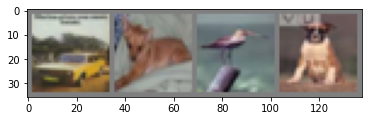

  car   dog  bird   dog


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
ws = Workspace.from_config() # this automatically looks for a directory .azureml
# ws.get_details()

datastore = ws.get_default_datastore()
datastore.upload(src_dir="./data", target_path="data/cifar10", overwrite=True)

WARNING - Warning: Falling back to use azure cli login credentials.
If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Uploading an estimated of 9 files
Uploading ./data/cifar-10-batches-py/batches.meta
Uploaded ./data/cifar-10-batches-py/batches.meta, 1 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/readme.html
Uploaded ./data/cifar-10-batches-py/readme.html, 2 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/test_batch
Uploaded ./data/cifar-10-batches-py/test_batch, 3 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/data_batch_2
Uploaded ./data/cifar-10-batches-py/data_batch_2, 4 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/data_batch_3
Uploaded ./data/cifar-10-batches-py/data_batch_3, 5 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/data_batch_4
Uploaded ./data/cifar-10-batches-py/data_batch_4, 6 files out of an estimated total of 9
Uploading ./data/cifar-10-batches-py/data_batch_1
Uploaded ./data/cifar-10-batches-py/data_batch_1, 7 files out of an estimated total of 9

$AZUREML_DATAREFERENCE_de4bd4704882444987a918981b0ade81

In [6]:
# Choose a name for your CPU cluster
cpu_cluster_name = "msai-ds3v2-04"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                            max_nodes=4, 
                                                            idle_seconds_before_scaledown=2400)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Set up Training Scripts

In [7]:
training_folder = os.path.join(os.getcwd(), "training")
os.makedirs(training_folder, exist_ok=True)

In [8]:
%%writefile $training_folder/train.py
import os
import argparse
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from model import Net
from azureml.core import Run

run = Run.get_context()

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data_path',
        type=str,
        help='Path to the training data'
    )
    parser.add_argument(
        '--learning_rate',
        type=float,
        default=0.001,
        help='Learning rate for SGD'
    )
    parser.add_argument(
        '--momentum',
        type=float,
        default=0.9,
        help='Momentum for SGD'
    )

    args = parser.parse_args()

    print("===== DATA =====")
    print("DATA PATH: " + args.data_path)
    print("LIST FILES IN DATA PATH...")
    print(os.listdir(args.data_path))
    print("================")

    # prepare DataLoader for CIFAR10 data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    trainset = torchvision.datasets.CIFAR10(
        root=args.data_path,
        train=True,
        download=False,
        transform=transform,
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

    # define convolutional network
    net = Net()

    # set up pytorch loss /  optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=args.learning_rate,
        momentum=args.momentum,
    )

    # train the network
    for epoch in range(2):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # unpack the data
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                loss = running_loss / 2000
                run.log('loss', loss)  # log loss metric to AML
                print(f'epoch={epoch + 1}, batch={i + 1:5}: loss {loss:.2f}')
                running_loss = 0.0

    print("Finished Training")

    PATH = "cifar_net.pt"
    torch.save(net.state_dict(), PATH)
    run.upload_file(name=PATH, path_or_stream=PATH)

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/brikse1/code/Users/BRIKSE1_demo/pytorch-use-cases-azure-ml/stanford_dogs_image_classification/training/train.py


# Set up Pytorch Environment

In [9]:
# Display AML Curated Environments
# Curated environments are backed by cached Docker images, reducing the run preparation cost.
envs = Environment.list(workspace=ws)

for env in envs:
    if env.startswith("AzureML"):
        print("Name", env)
        print("packages", envs[env].python.conda_dependencies.serialize_to_string())

Name AzureML-AutoML
packages channels:
- anaconda
- conda-forge
- pytorch
dependencies:
- python=3.6.2
- pip=20.2.4
- pip:
  - azureml-core==1.19.0
  - azureml-pipeline-core==1.19.0
  - azureml-telemetry==1.19.0
  - azureml-defaults==1.19.0
  - azureml-interpret==1.19.0
  - azureml-automl-core==1.19.0
  - azureml-automl-runtime==1.19.0
  - azureml-train-automl-client==1.19.0
  - azureml-train-automl-runtime==1.19.0
  - azureml-dataset-runtime==1.19.0
  - inference-schema
  - py-cpuinfo==5.0.0
  - boto3==1.15.18
  - botocore==1.18.18
- numpy~=1.18.0
- scikit-learn==0.22.1
- pandas~=0.25.0
- py-xgboost<=0.90
- fbprophet==0.5
- holidays==0.9.11
- setuptools-git
- psutil>5.0.0,<6.0.0
name: azureml_8eff28b157f42edcd2424a5aae6c8074

Name AzureML-PyTorch-1.0-GPU
packages channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.19.0
  - azureml-defaults==1.19.0
  - azureml-telemetry==1.19.0
  - azureml-train-restclients-hyperdrive==1.19.0
  - azureml-train-core==1.19.0
 

In [10]:
for name,env in ws.environments.items():
    print(f"Name {name} \t version {env.version}")

# restored_environment = Environment.get(workspace=ws,name="myenv",version="1")

print("Attributes of restored environment")
# restored_environment

Name mnist-env 	 version 5
Name myenv 	 version 4
Name pytorch-aml-env 	 version 1
Name environment 	 version 1
Name AutoML-Non-Prod 	 version 4
Name AutoML-DNN-Non-Prod 	 version 4
Name AutoML-GPU-Non-Prod 	 version 4
Name AutoML-DNN-GPU-Non-Prod 	 version 4
Name AzureML-AutoML 	 version 50
Name AzureML-PyTorch-1.0-GPU 	 version 44
Name AzureML-Scikit-learn-0.20.3 	 version 43
Name AzureML-TensorFlow-1.12-CPU 	 version 42
Name AzureML-PyTorch-1.2-GPU 	 version 44
Name AzureML-TensorFlow-2.0-GPU 	 version 42
Name AzureML-TensorFlow-2.0-CPU 	 version 41
Name AzureML-Chainer-5.1.0-GPU 	 version 44
Name AzureML-TensorFlow-1.13-CPU 	 version 43
Name AzureML-Minimal 	 version 44
Name AzureML-Chainer-5.1.0-CPU 	 version 43
Name AzureML-PyTorch-1.4-GPU 	 version 34
Name AzureML-PySpark-MmlSpark-0.15 	 version 39
Name AzureML-PyTorch-1.3-CPU 	 version 39
Name AzureML-PyTorch-1.1-GPU 	 version 44
Name AzureML-TensorFlow-1.10-GPU 	 version 44
Name AzureML-PyTorch-1.2-CPU 	 version 43
Name AzureM

In [11]:
curated_env = Environment.get(workspace=ws, name="AzureML-PyTorch-1.3-CPU")
print(curated_env.docker.base_image)

mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1


In [12]:
# On the first run in given environment, Azure ML spends some time building the environment.
# On the subsequent runs, Azure ML keeps track of changes and uses the existing environment, 
# resulting in faster run completion.

env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="environment.yml")

env.docker.enabled = True
# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

# OPTION 1: Use mcr base image
env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"

# OPTION 2: Use custom base image
#env.docker.base_image = "myregistry.azurecr.io/mycustomimage:1.0"
#env.docker.base_image_registry.address = "myregistry.azurecr.io"
#env.docker.base_image_registry.username = "username"
#env.docker.base_image_registry.password = "password"

# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}
# This can be retrieved in training script with os.environ.get("MESSAGE")

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": true,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "MESSAGE": "Hello from Azure Machine Learning"
    },
    "inferencingStackVersion": null,
    "name": "pytorch-aml-env",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "pytorch"
            ],
  

In [13]:
dataset = Dataset.File.from_files(path=(datastore, "data/cifar10"))
dataset = dataset.register(workspace=ws,
                           name="cifar10-dataset",
                           description="cifar10 training dataset",
                           create_new_version=True)

experiment = Experiment(workspace=ws, 
                        name="cifar-image-classification-pytorch")

config = ScriptRunConfig(source_directory="training",
                         script="train.py",
                         compute_target=cpu_cluster_name,
                         arguments=[
                             "--data_path", dataset.as_named_input("input").as_mount(),
                             "--learning_rate", 0.003,
                             "--momentum", 0.92])

config.run_config.environment = env

run = experiment.submit(config)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [14]:
run.wait_for_completion(show_output=False)

{'runId': 'cifar-image-classification-pytorch_1610022440_3a9fb6fe',
 'target': 'msai-ds3v2-04',
 'status': 'Completed',
 'startTimeUtc': '2021-01-07T12:43:43.235687Z',
 'endTimeUtc': '2021-01-07T12:48:47.470045Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'ca023c5d-fc8c-4744-9860-825235f9dc10',
  'azureml.git.repository_uri': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'mlflow.source.git.repoURL': 'https://github.com/sebastianbirk/pytorch-use-cases-azure-ml.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '61e3ec522ae2e1c49c333de6dc04eafe472f2858',
  'mlflow.source.git.commit': '61e3ec522ae2e1c49c333de6dc04eafe472f2858',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '454d0a25-97df-4ef8-8a7c-58fc967448d6'}, 'consumptionDetails': {'

In [15]:
print(run.get_metrics())
print(run.get_file_names())

{'loss': [2.0413564110696316, 1.7357404006272554, 1.6161067148000001, 1.5915769870132208, 1.5596799415498972, 1.5253833034932613, 1.474745139680803, 1.5081596463024616, 1.4987276076860725, 1.5030428788289427, 1.5029170999862254, 1.4870155130643397]}
['azureml-logs/20_image_build_log.txt', 'azureml-logs/55_azureml-execution-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/65_job_prep-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_0d7303ef0d6ada456d45b477c5e2304e2af9832a7417ade85fedf1d5abf38cba_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'cifar_net.pt', 'logs/azureml/79_azureml.log', 'logs/azureml/dataprep/backgroundProcess.log', 'logs/azureml/dataprep/backgroundProcess_Telemetry.log', 'logs/azureml/dataprep/engine_spans_565d07a1-9849-4fff-b50f-f815a0065d23.jsonl', 'logs/azureml/dataprep/engine_spans_e5a231dc-b108-

In [16]:
PATH = "cifar_net.pt"

model = run.register_model(model_name="cifar10-model",
                           model_path=PATH,
                           model_framework=Model.Framework.PYTORCH,
                           description="cifar10 model")

In [17]:
env.inferencing_stack_version = "latest"
# This will install the inference specific apt packages.

In [18]:
deployment_folder = os.path.join(os.getcwd(), "deployment")
os.makedirs(deployment_folder, exist_ok=True)

In [19]:
%%writefile $deployment_folder/score.py
import os
import torch
import json
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def init():
    global net
    global classes

    model_filename = "cifar_net.pt"
    model_path = os.path.join(os.environ['AZUREML_MODEL_DIR'], model_filename)
    net = Net()
    net.load_state_dict(torch.load(model_path))
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def run(data):
    data = json.loads(data)
    images = torch.FloatTensor(data['data'])
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    result = [classes[predicted[j]] for j in range(4)]
    result_json = json.dumps({"predictions": result})

    # You can return any JSON-serializable object.
    return result_json

Overwriting /mnt/batch/tasks/shared/LS_root/mounts/clusters/brikse1/code/Users/BRIKSE1_demo/pytorch-use-cases-azure-ml/stanford_dogs_image_classification/deployment/score.py


In [21]:
# Create Inference Config
inference_config = InferenceConfig(entry_script="deployment/score.py",
                                   environment=env)

# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=False,
                        image_name="cifar10-pytorch",
                        image_label="1.0")

package.wait_for_creation(show_output=True)

# Download the image. This can only be used if generate_dockerfile is set to False
# package.pull()

# Download the dockerfile. This can only be used if generate_dockerfile is set to True
# package.save("./docker")

2021/01/07 12:48:58 Downloading source code...
2021/01/07 12:49:00 Finished downloading source code
2021/01/07 12:49:01 Creating Docker network: acb_default_network, driver: 'bridge'
2021/01/07 12:49:04 Successfully set up Docker network: acb_default_network
2021/01/07 12:49:04 Setting up Docker configuration...
2021/01/07 12:49:05 Successfully set up Docker configuration
2021/01/07 12:49:05 Logging in to registry: 5c5bd98e724841e884500ebf807070c9.azurecr.io
2021/01/07 12:49:06 Successfully logged into 5c5bd98e724841e884500ebf807070c9.azurecr.io
2021/01/07 12:49:06 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/01/07 12:49:06 Scanning for dependencies...
2021/01/07 12:49:07 Successfully scanned dependencies
2021/01/07 12:49:07 Launching container with name: acb_step_0
Sending build context to Docker daemon  65.02kB
Step 1/22 : FROM mcr.microsoft.com/azureml/o16n-base/python-assets:latest AS inferencing-assets
latest: Pullin

WebserviceException: WebserviceException:
	Message: Package creation reached non-successful terminal state.
State: Failed
Error:
StatusCode: 400
Message: Environment image build failed.

	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Package creation reached non-successful terminal state.\nState: Failed\nError:\nStatusCode: 400\nMessage: Environment image build failed.\n"
    }
}

In [22]:
# Create Inference Config
inference_config = InferenceConfig(entry_script="deployment/score.py",
                                   environment=env)

# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=True,
                        image_name="cifar10-pytorch",
                        image_label="1.0")

package.wait_for_creation(show_output=True)

# Download the image. This can only be used if generate_dockerfile is set to False
# package.pull()

# Download the dockerfile. This can only be used if generate_dockerfile is set to True
# package.save("./docker")

Package creation Succeeded


![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/get-started-day1/day1-part4-data.png)

In [17]:
!python training/train.py --data_path ./data --learning_rate 0.003 --momentum 0.92

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (pyOpenSSL 20.0.0 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('pyopenssl<20.0.0'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:St

In [18]:
from azureml.core.authentication import InteractiveLoginAuthentication
interactive_auth = InteractiveLoginAuthentication(tenant_id="your-tenant-id")
Additional details on authentication can be found here: https://aka.ms/aml-notebook-auth 

SyntaxError: invalid syntax (<ipython-input-18-aa630af4f9d4>, line 3)

In [ ]:
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

mnist_file_dataset = mnist_file_dataset.register(workspace=ws,
                                                 name='mnist_opendataset',
                                                 description='training and test dataset',
                                                 create_new_version=True)

In [ ]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the dataset to mount or download, and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(glob.glob(os.path.join(data_folder, '**/train-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
X_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-images-idx3-ubyte.gz'), recursive=True)[0], False) / 255.0
y_train = load_data(glob.glob(os.path.join(data_folder, '**/train-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)
y_test = load_data(glob.glob(os.path.join(data_folder, '**/t10k-labels-idx1-ubyte.gz'), recursive=True)[0], True).reshape(-1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

In [ ]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', mnist_file_dataset.as_mount(), '--regularization', 0.5]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [ ]:
from azureml.core import Workspace
ws = Workspace.from_config()
datastore = ws.get_default_datastore()
datastore.upload(src_dir='./data', target_path='datasets/cifar10', overwrite=True)

The `target_path` specifies the path on the datastore where the CIFAR10 data will be uploaded.

## Submit your machine learning code to Azure Machine Learning

As you have done previously, create a new Python control script:

### Understand the control code

The above control code has the following additional code compared to the control code written in [previous tutorial](03-train-model.ipynb)

**`dataset = Dataset.File.from_files(path=(datastore, 'datasets/cifar10'))`**: A Dataset is used to reference the data you uploaded to the Azure Blob Store. Datasets are an abstraction layer on top of your data that are designed to improve reliability and trustworthiness.


**`config = ScriptRunConfig(...)`**: We modified the `ScriptRunConfig` to include a list of arguments that will be passed into `train.py`. We also specified `dataset.as_named_input('input').as_mount()`, which means the directory specified will be _mounted_ to the compute target.

## Inspect the 70_driver_log log file

In the navigate to the 70_driver_log.txt file - you should see the following output:

```
Processing 'input'.
Processing dataset FileDataset
{
  "source": [
    "('workspaceblobstore', 'datasets/cifar10')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "XXXXX",
    "name": null,
    "version": null,
    "workspace": "Workspace.create(name='XXXX', subscription_id='XXXX', resource_group='X')"
  }
}
Mounting input to /tmp/tmp9kituvp3.
Mounted input to /tmp/tmp9kituvp3 as folder.
Exit __enter__ of DatasetContextManager
Entering Run History Context Manager.
Current directory:  /mnt/batch/tasks/shared/LS_root/jobs/dsvm-aml/azureml/tutorial-session-3_1600171983_763c5381/mounts/workspaceblobstore/azureml/tutorial-session-3_1600171983_763c5381
Preparing to call script [ train.py ] with arguments: ['--data_path', '$input', '--learning_rate', '0.003', '--momentum', '0.92']
After variable expansion, calling script [ train.py ] with arguments: ['--data_path', '/tmp/tmp9kituvp3', '--learning_rate', '0.003', '--momentum', '0.92']

Script type = None
===== DATA =====
DATA PATH: /tmp/tmp9kituvp3
LIST FILES IN DATA PATH...
['cifar-10-batches-py', 'cifar-10-python.tar.gz']
```

Notice:

1. Azure Machine Learning has mounted the blob store to the compute cluster automatically for you.
2. The ``dataset.as_named_input('input').as_mount()`` used in the control script resolves to the mount point
3. In the machine learning code we include a line to list the directorys under the data directory - you can see the list above.

## Clean up resources

The compute cluster will scale down to zero after 40minutes of idle time. When the compute is idle you will not be charged. If you want to delete the cluster use:


In [ ]:
from azureml.core import Workspace

ws = Workspace.from_config()
ct = ws.compute_targets['cpu-cluster']
# ct.delete()

If you're not going to use what you've created here, delete the resources you just created with this quickstart so you don't incur any charges for storage. In the Azure portal, select and delete your resource group.

## Next Steps

To learn more about the capabilities of Azure Machine Learning please refer to the following documentation:

* [Azure Machine Learning Pipelines](https://docs.microsoft.com/en-us/azure/machine-learning/concept-ml-pipelines#building-pipelines-with-the-python-sdk)
* [Deploy models for real-time scoring](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-deploy-models-with-aml)
* [Hyper parameter tuning with Azure Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters)
* [Prep your code for production](https://docs.microsoft.com/azure/machine-learning/tutorial-convert-ml-experiment-to-production)

## Test the model service
In the next cell, you get some unseen data from the test loader:

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import json

input_payload = json.dumps({
    'data': images.tolist()
})

output = service.run(input_payload)
print(output)